# Peter und der Wolf: Realistische Umgebung

In unserer Situation konnte Peter sich fast ohne Müdigkeit oder Hunger bewegen. In einer realistischeren Welt muss er sich von Zeit zu Zeit hinsetzen und ausruhen sowie sich ernähren. Lassen Sie uns unsere Welt realistischer gestalten, indem wir die folgenden Regeln umsetzen:

1. Beim Bewegen von einem Ort zum anderen verliert Peter **Energie** und sammelt **Müdigkeit**.
2. Peter kann mehr Energie gewinnen, indem er Äpfel isst.
3. Peter kann Müdigkeit loswerden, indem er sich unter einem Baum oder auf dem Gras ausruht (d.h. indem er ein Feld mit einem Baum oder Gras betritt - grünes Feld).
4. Peter muss den Wolf finden und töten.
5. Um den Wolf zu töten, muss Peter bestimmte Energie- und Müdigkeitslevel haben, andernfalls verliert er den Kampf.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from rlboard import *

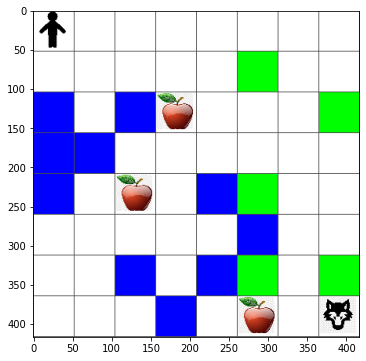

In [2]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

In [3]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

## Definition des Zustands

In unseren neuen Spielregeln müssen wir bei jedem Spielzustand Energie und Erschöpfung im Blick behalten. Daher erstellen wir ein Objekt `state`, das alle notwendigen Informationen über den aktuellen Problemzustand enthält, einschließlich des Zustands des Spielfelds, der aktuellen Energie- und Erschöpfungswerte und der Frage, ob wir den Wolf im Endzustand besiegen können:


In [4]:
class state:
    def __init__(self,board,energy=10,fatigue=0,init=True):
        self.board = board
        self.energy = energy
        self.fatigue = fatigue
        self.dead = False
        if init:
            self.board.random_start()
        self.update()

    def at(self):
        return self.board.at()

    def update(self):
        if self.at() == Board.Cell.water:
            self.dead = True
            return
        if self.at() == Board.Cell.tree:
            self.fatigue = 0
        if self.at() == Board.Cell.apple:
            self.energy = 10

    def move(self,a):
        self.board.move(a)
        self.energy -= 1
        self.fatigue += 1
        self.update()

    def is_winning(self):
        return self.energy > self.fatigue

Lass uns versuchen, das Problem mit einem Random Walk zu lösen und sehen, ob wir Erfolg haben:


In [5]:
def random_policy(state):
    return random.choice(list(actions))

def walk(board,policy):
    n = 0 # number of steps
    s = state(board)
    while True:
        if s.at() == Board.Cell.wolf:
            if s.is_winning():
                return n # success!
            else:
                return -n # failure!
        if s.at() == Board.Cell.water:
            return 0 # died
        a = actions[policy(m)]
        s.move(a)
        n+=1

walk(m,random_policy)

0

In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        elif z==0:
            n+=1
        else:
            s+=1
    print(f"Killed by wolf = {w}, won: {s} times, drown: {n} times")

print_statistics(random_policy)

Killed by wolf = 5, won: 1 times, drown: 94 times


## Belohnungsfunktion

### Einführung
Die Belohnungsfunktion ist ein entscheidender Bestandteil des Verstärkungslernens. Sie dient als Leitfaden für den Agenten, um zu verstehen, welche Aktionen wünschenswert sind und welche vermieden werden sollten.

### Aufbau einer Belohnungsfunktion
Eine gut gestaltete Belohnungsfunktion sollte:
- Klar definierte Ziele haben.
- Den Agenten dazu motivieren, langfristige Belohnungen zu maximieren.
- Negative Belohnungen für unerwünschtes Verhalten enthalten.

### Beispiele
Hier sind einige Beispiele für Belohnungsfunktionen:
1. **Navigation**: Belohne den Agenten für das Erreichen eines Ziels und bestrafe ihn für Kollisionen.
2. **Spielstrategie**: Belohne den Agenten für das Gewinnen eines Spiels und bestrafe ihn für Regelverstöße.
3. **Ressourcenmanagement**: Belohne den Agenten für effiziente Ressourcennutzung und bestrafe ihn für Verschwendung.

### Häufige Fehler
- **Übermäßige Bestrafung**: Zu viele negative Belohnungen können den Agenten entmutigen.
- **Unklare Ziele**: Wenn die Belohnungsfunktion nicht klar definiert ist, kann der Agent inkonsistente Ergebnisse liefern.
- **Kurzfristige Belohnungen**: Wenn die Belohnungsfunktion nur kurzfristige Gewinne priorisiert, kann der Agent langfristige Ziele ignorieren.

### Fazit
Die Gestaltung einer effektiven Belohnungsfunktion erfordert sorgfältige Planung und Tests. Sie ist entscheidend für den Erfolg eines Verstärkungslernungsmodells.


In [7]:
def reward(s):
    r = s.energy-s.fatigue
    if s.at()==Board.Cell.wolf:
        return 100 if s.is_winning() else -100
    if s.at()==Board.Cell.water:
        return -100
    return r

## Q-Learning-Algorithmus

Der eigentliche Lernalgorithmus bleibt weitgehend unverändert, wir verwenden lediglich `state` anstelle der reinen Brettposition.


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

In [9]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

In [10]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    s = state(m)
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = s.board.human
        v = probs(Q[x,y])
        while True:
            a = random.choices(list(actions),weights=v)[0]
            dpos = actions[a]
            if s.board.is_valid(s.board.move_pos(s.board.human,dpos)):
                break 
        s.move(dpos)
        r = reward(s)
        if abs(r)==100: # end of game
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

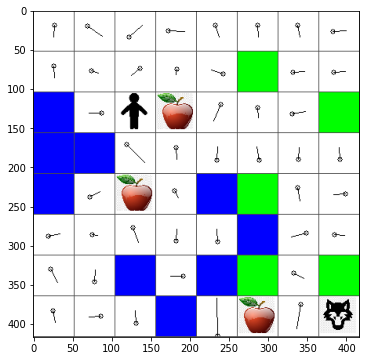

In [11]:
m.plot(Q)

## Ergebnisse

Schauen wir mal, ob wir erfolgreich waren, Peter darauf vorzubereiten, gegen den Wolf zu kämpfen!


In [12]:
def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Killed by wolf = 1, won: 9 times, drown: 90 times


Wir sehen jetzt viel weniger Fälle von Ertrinken, aber Peter ist immer noch nicht immer in der Lage, den Wolf zu töten. Versuchen Sie zu experimentieren und sehen Sie, ob Sie dieses Ergebnis durch das Spielen mit Hyperparametern verbessern können.


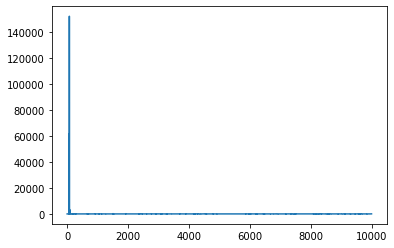

In [13]:
plt.plot(lpath)


---

**Haftungsausschluss**:  
Dieses Dokument wurde mit dem KI-Übersetzungsdienst [Co-op Translator](https://github.com/Azure/co-op-translator) übersetzt. Obwohl wir uns um Genauigkeit bemühen, beachten Sie bitte, dass automatisierte Übersetzungen Fehler oder Ungenauigkeiten enthalten können. Das Originaldokument in seiner ursprünglichen Sprache sollte als maßgebliche Quelle betrachtet werden. Für kritische Informationen wird eine professionelle menschliche Übersetzung empfohlen. Wir übernehmen keine Haftung für Missverständnisse oder Fehlinterpretationen, die sich aus der Nutzung dieser Übersetzung ergeben.
